In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Import and visualize data

In [2]:
# process outflow data
outflow_data = pd.read_csv('4200 Modified Average Daily Streamflows.csv')
outflow_data.rename(columns={'Ice Harbor Daily Streamflows (unit:cfs)': 'Ice Harbor outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Monumental (unit:cfs)': 'Lower Monumental outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Little Goose (unit:cfs)': 'Little Goose outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Granite (unit:cfs)': 'Lower Granite outflow (cfs)'}, inplace=True)
outflow_data['date'] = pd.to_datetime(outflow_data['date'])
outflow_data['Ice Harbor outflow (cfs)'] = pd.to_numeric(outflow_data['Ice Harbor outflow (cfs)'])
outflow_data.rename(columns={'date':'datetime'}, inplace=True)

# process precipitation data for runoff calculations
precip_data = pd.read_csv('NOAAprecipitation_data_LEWISTON_AIRPORT_ID.csv')
precip_data = precip_data.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'SNWD', 'SNOW'], axis=1)
precip_data.rename(columns={'PRCP':'rainfall (in)', 'DATE':'datetime'}, inplace=True)
precip_data['datetime'] = pd.to_datetime(precip_data['datetime'], format='%Y-%m-%d')
precip_data['rainfall (in)'] = precip_data['rainfall (in)'].fillna(0) #replaces nan with 0

# process Clearwater River flow
upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
upstream_flow = upstream_flow.drop(0)
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
upstream_flow = upstream_flow.drop(['agency_cd', 'site_no', 'tz_cd', '191671_00060_cd'], axis=1)
upstream_flow.rename(columns={'191671_00060':'upstream flow (cfs)'}, inplace=True)
upstream_flow['upstream flow (cfs)'] = pd.to_numeric(upstream_flow['upstream flow (cfs)'], errors='coerce')
upstream_flow = upstream_flow.groupby('datetime')['upstream flow (cfs)'].mean().reset_index()
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'])

# process Snake river flow
snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)
snake_flow = snake_flow.drop(0)
snake_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
snake_flow = snake_flow.drop(['agency_cd', 'site_no', 'tz_cd', '151907_00060_cd'], axis=1)
snake_flow.rename(columns={'151907_00060':'Snake flow (cfs)'}, inplace=True)
snake_flow['Snake flow (cfs)'] = pd.to_numeric(snake_flow['Snake flow (cfs)'], errors='coerce')
snake_flow = snake_flow.groupby('datetime')['Snake flow (cfs)'].mean().reset_index()
snake_flow['datetime'] = pd.to_datetime(snake_flow['datetime'])

# process Tucannon river flow
tucannon_flow = pd.read_csv('tucannonriverdailymean.txt', sep='\t', header=25)
tucannon_flow = tucannon_flow.drop(0)
tucannon_flow = tucannon_flow.drop(['agency_cd', 'site_no', '150225_00060_00003_cd'], axis=1)
tucannon_flow.rename(columns={'150225_00060_00003':'Tucannon flow (cfs)'}, inplace=True)
tucannon_flow['datetime'] = pd.to_datetime(tucannon_flow['datetime'], format='%Y-%m-%d')
tucannon_flow['Tucannon flow (cfs)'] = pd.to_numeric(tucannon_flow['Tucannon flow (cfs)'], errors='coerce')

# process Palouse river flow
palouse_flow = pd.read_csv('palouseriverdailydischarge.csv', usecols=['time','value'])
palouse_flow.rename(columns={'value':'Palouse flow (cfs)', 'time':'datetime'}, inplace=True)
palouse_flow['datetime'] = pd.to_datetime(palouse_flow['datetime'], format='%Y-%m-%d')
palouse_flow['Palouse flow (cfs)'] = pd.to_numeric(palouse_flow['Palouse flow (cfs)'], errors='coerce')

# merge Tucannon and Palouse
lower_mon_trib = palouse_flow.merge(tucannon_flow, how='inner', on=['datetime'])
lower_mon_trib['Tributary flow (cfs)'] = lower_mon_trib['Palouse flow (cfs)'] + lower_mon_trib['Tucannon flow (cfs)']
lower_mon_trib = lower_mon_trib.drop(['Palouse flow (cfs)','Tucannon flow (cfs)'], axis=1)

# merge the dataframes
flow_data = outflow_data.merge(upstream_flow, how='inner', on=['datetime'])
input_data = flow_data.merge(precip_data, how='inner', on=['datetime'])
input_data = input_data.merge(snake_flow, how='inner', on=['datetime'])
input_data['upstream flow (cfs)'] = input_data['upstream flow (cfs)'] + input_data['Snake flow (cfs)']
input_data = input_data.merge(lower_mon_trib, how='inner', on=['datetime'])
input_data = input_data.drop(columns='Snake flow (cfs)')

input_data = input_data[input_data['datetime'] > datetime(1995,1,1)]

display(input_data)

/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_64723/1452603532.py:19: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_64723/1452603532.py:29: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0
...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5


### Visualize one year

Text(0, 0.5, 'Outflow data from each dam (cfs)')

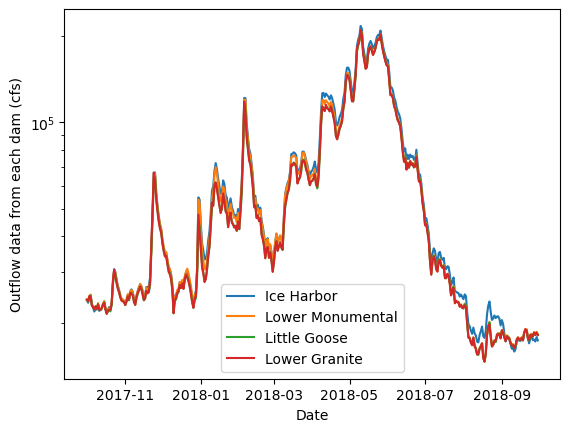

In [3]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=outflow_data[-365:], label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=outflow_data[-365:], label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=outflow_data[-365:], label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=outflow_data[-365:], label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

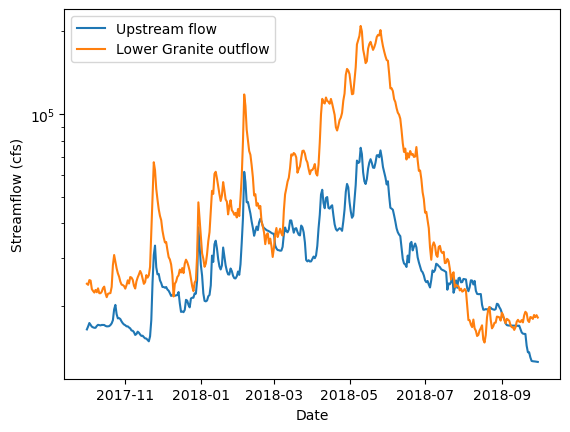

In [4]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data[-365:], label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data[-365:], label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

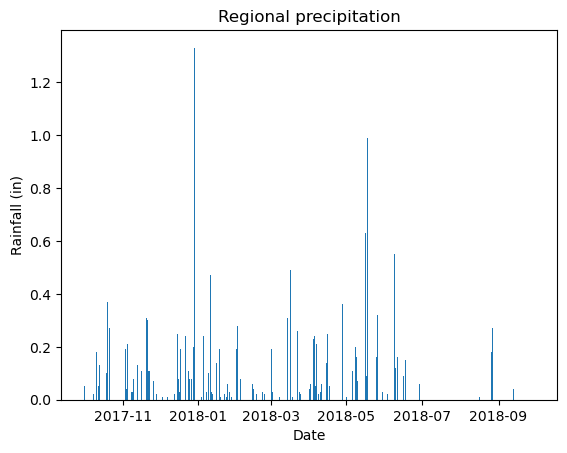

In [5]:
plt.bar(x=input_data['datetime'][-365:], height=input_data['rainfall (in)'][-365:])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

### Visualize entire dataset

Text(0, 0.5, 'Outflow data from each dam (cfs)')

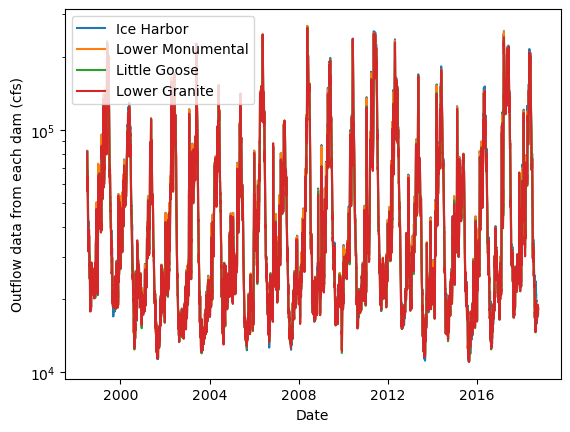

In [6]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

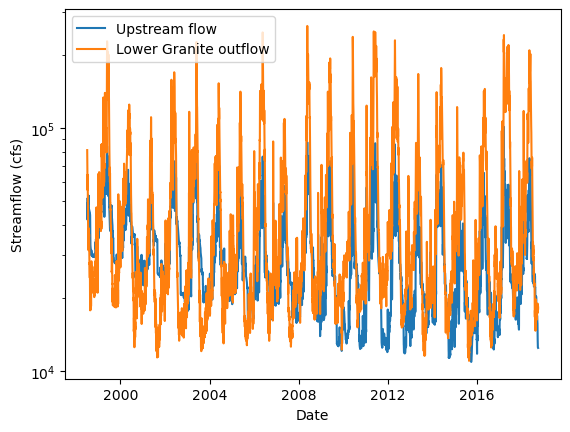

In [7]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data, label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

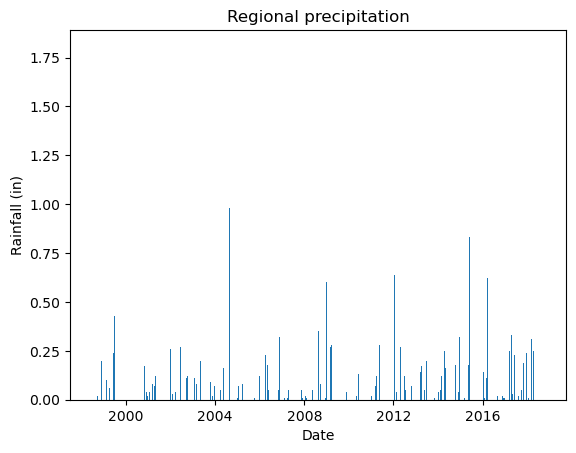

In [8]:
plt.bar(x=input_data['datetime'], height=input_data['rainfall (in)'])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

## Initialize reservoirs

In [9]:
from Reservoir import Reservoir

ice_harbor = Reservoir(SA=9200*4047,num_turb=6,capacity=603000,tail_elev=339,pool_elev=446,bottom_elev=310,fish_pass=0.965, area=550_000_000)
lower_monumental = Reservoir(SA=6590*4047,num_turb=6,capacity=810000,tail_elev=439,pool_elev=548.3,bottom_elev=406,fish_pass=0.965, area=1_610_000_000)
little_goose = Reservoir(SA=10025*4047,num_turb=6,capacity=903000,tail_elev=539,pool_elev=646.5,bottom_elev=500,fish_pass=0.9775, area=1_175_000_000)
lower_granite = Reservoir(SA=8900*4047,num_turb=6,capacity=810000,tail_elev=636,pool_elev=746.5,bottom_elev=590,fish_pass=1, area=2_477_000_000)

## Simulate reservoir storage

### Lower Granite

In [10]:
mult = 2
input_data['Lower Granite inflow (m^3/d)'] = lower_granite.simulate_inflow(input_data['rainfall (in)'].values, input_data['upstream flow (cfs)'].values)
runoff = lower_granite.calc_runoff(input_data['rainfall (in)'].values)
input_data['Lower granite storage (m^3)'] = lower_granite.simulate_storage(4_000_000_000, 1, mult*input_data['Lower Granite inflow (m^3/d)'].values, input_data['Lower Granite outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,4.039268e+09
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,4.081182e+09
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,4.126089e+09
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,4.185436e+09
...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,4.414207e+09
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,4.430289e+09
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,4.447093e+09
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,4.463030e+09


Text(0, 0.5, 'Flow volumes (m^3/d)')

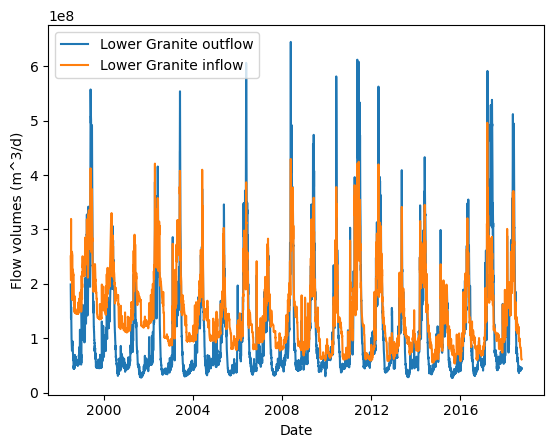

In [11]:
plt.plot(input_data['datetime'], input_data['Lower Granite outflow (cfs)']*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'], mult*input_data['Lower Granite inflow (m^3/d)'], label='Lower Granite inflow')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Flow volumes (m^3/d)')

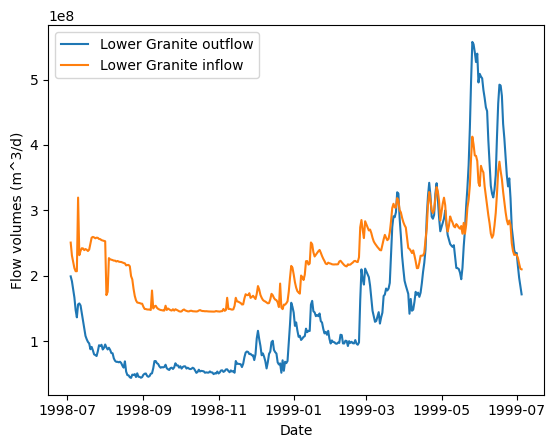

In [12]:
plt.plot(input_data['datetime'][:365], input_data['Lower Granite outflow (cfs)'][:365]*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'][:365], mult*input_data['Lower Granite inflow (m^3/d)'][:365], label='Lower Granite inflow')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Flow volumes (m^3/d)')

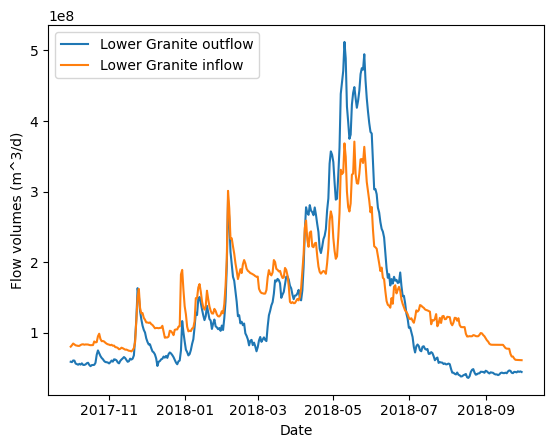

In [13]:
plt.plot(input_data['datetime'][-365:], input_data['Lower Granite outflow (cfs)'][-365:]*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'][-365:], mult*input_data['Lower Granite inflow (m^3/d)'][-365:], label='Lower Granite inflow')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Reservoir storage (m^3)')

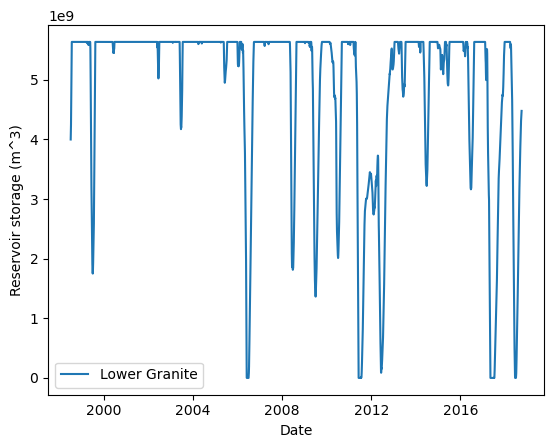

In [14]:
# sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
# sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
# sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Little Goose

In [15]:
input_data['Little Goose inflow (m^3/d)'] = little_goose.simulate_inflow(input_data['rainfall (in)'].values, input_data['Lower Granite outflow (cfs)'])
input_data['Little Goose storage (m^3)'] = little_goose.simulate_storage(5_900_000_000, 1, input_data['Little Goose inflow (m^3/d)'].values, input_data['Little Goose outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09,1.988958e+08,5.900000e+09
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,4.039268e+09,1.915262e+08,5.898061e+09
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,4.081182e+09,1.791393e+08,5.895931e+09
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,4.126089e+09,1.666472e+08,5.893051e+09
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,4.185436e+09,1.474847e+08,5.890486e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,4.414207e+09,4.381166e+07,5.872012e+09
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,4.430289e+09,4.528118e+07,5.872098e+09
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,4.447093e+09,4.448162e+07,5.872152e+09
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,4.463030e+09,4.521760e+07,5.872098e+09


Text(0, 0.5, 'Reservoir storage (m^3)')

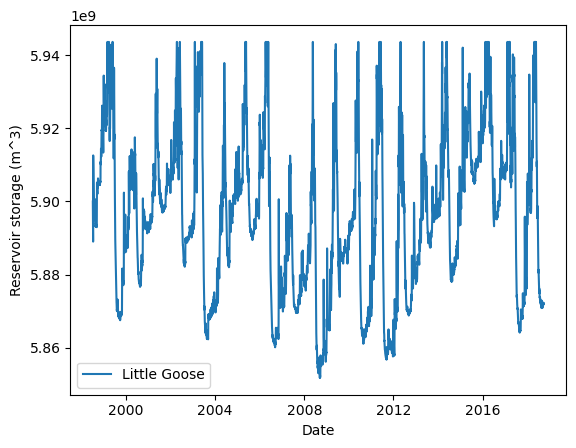

In [16]:
#sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Lower Monumental

In [30]:
lower_mon_inflow = 1.005*(input_data['Little Goose outflow (cfs)'] + input_data['Tributary flow (cfs)'])
input_data['Lower Monumental inflow (m^3/d)'] = lower_monumental.simulate_inflow(input_data['rainfall (in)'].values, lower_mon_inflow)
input_data['Lower Monumental storage (m^3)'] = lower_monumental.simulate_storage(3_700_000_000, 1, input_data['Lower Monumental inflow (m^3/d)'].values, input_data['Lower Monumental outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3),Lower Monumental inflow (m^3/d),Lower Monumental storage (m^3),Ice Harbor inflow (m^3/d),Ice Harbor storage (m^3),Ice Harbor hydropower (kWh),Lower Monumental hydropower (kWh),Little Goose hydropower (kWh),Lower Granite hydropower (kWh)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09,1.988958e+08,5.900000e+09,1.999075e+08,3.700000e+09,1.993017e+08,2.000000e+08,0.0,14472.0,21672.0,19440.0
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,4.039268e+09,1.915262e+08,5.898061e+09,1.950346e+08,3.700582e+09,1.944531e+08,1.963959e+08,0.0,14472.0,21672.0,19440.0
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,4.081182e+09,1.791393e+08,5.895931e+09,1.827872e+08,3.701102e+09,1.822666e+08,1.913003e+08,0.0,14472.0,21672.0,19440.0
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,4.126089e+09,1.666472e+08,5.893051e+09,1.709379e+08,3.701564e+09,1.704762e+08,1.849112e+08,0.0,14472.0,21672.0,19440.0
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,4.185436e+09,1.474847e+08,5.890486e+09,1.513504e+08,3.701926e+09,1.509886e+08,1.784096e+08,0.0,14472.0,21672.0,19440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,4.414207e+09,4.381166e+07,5.872012e+09,4.444822e+07,7.748918e+08,4.417843e+07,1.737258e+07,0.0,14472.0,21672.0,19440.0
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,4.430289e+09,4.528118e+07,5.872098e+09,4.577470e+07,7.751701e+08,4.549635e+07,2.001575e+07,0.0,14472.0,21672.0,19440.0
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,4.447093e+09,4.448162e+07,5.872152e+09,4.499965e+07,7.754461e+08,4.472369e+07,2.257335e+07,0.0,14472.0,21672.0,19440.0
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,4.463030e+09,4.521760e+07,5.872098e+09,4.584793e+07,7.757243e+08,4.556970e+07,2.446587e+07,0.0,14472.0,21672.0,19440.0


Text(0, 0.5, 'Reservoir storage (m^3)')

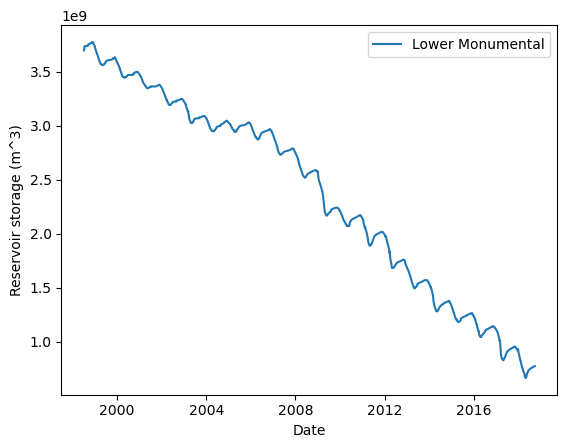

In [31]:
#sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
#sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Monumental storage (m^3)', data=input_data, label='Lower Monumental')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Ice Harbor

In [42]:
input_data['Ice Harbor inflow (m^3/d)'] = ice_harbor.simulate_inflow(input_data['rainfall (in)'].values, input_data['Lower Monumental outflow (cfs)'])
input_data['Ice Harbor storage (m^3)'] = ice_harbor.simulate_storage(4_000_000_000, 1, 1.02*input_data['Ice Harbor inflow (m^3/d)'].values, input_data['Ice Harbor outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3),Lower Monumental inflow (m^3/d),Lower Monumental storage (m^3),Ice Harbor inflow (m^3/d),Ice Harbor storage (m^3),Ice Harbor hydropower (kWh),Lower Monumental hydropower (kWh),Little Goose hydropower (kWh),Lower Granite hydropower (kWh)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09,1.988958e+08,5.900000e+09,1.999075e+08,3.700000e+09,1.993017e+08,4.000000e+09,0.0,14472.0,21672.0,19440.0
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,4.039268e+09,1.915262e+08,5.898061e+09,1.950346e+08,3.700582e+09,1.944531e+08,4.000285e+09,0.0,14472.0,21672.0,19440.0
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,4.081182e+09,1.791393e+08,5.895931e+09,1.827872e+08,3.701102e+09,1.822666e+08,3.998835e+09,0.0,14472.0,21672.0,19440.0
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,4.126089e+09,1.666472e+08,5.893051e+09,1.709379e+08,3.701564e+09,1.704762e+08,3.995855e+09,0.0,14472.0,21672.0,19440.0
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,4.185436e+09,1.474847e+08,5.890486e+09,1.513504e+08,3.701926e+09,1.509886e+08,3.992373e+09,0.0,14472.0,21672.0,19440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,4.414207e+09,4.381166e+07,5.872012e+09,4.444822e+07,7.748918e+08,4.417843e+07,3.554335e+09,0.0,14472.0,21672.0,19440.0
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,4.430289e+09,4.528118e+07,5.872098e+09,4.577470e+07,7.751701e+08,4.549635e+07,3.557889e+09,0.0,14472.0,21672.0,19440.0
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,4.447093e+09,4.448162e+07,5.872152e+09,4.499965e+07,7.754461e+08,4.472369e+07,3.561341e+09,0.0,14472.0,21672.0,19440.0
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,4.463030e+09,4.521760e+07,5.872098e+09,4.584793e+07,7.757243e+08,4.556970e+07,3.564145e+09,0.0,14472.0,21672.0,19440.0


Text(0, 0.5, 'Reservoir storage (m^3)')

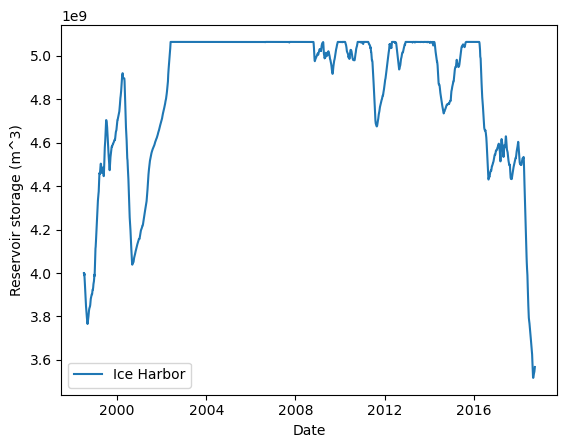

In [43]:
sns.lineplot(x='datetime', y='Ice Harbor storage (m^3)', data=input_data, label='Ice Harbor')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Visualize all reservoirs

Text(0, 0.5, 'Reservoir storage (m^3)')

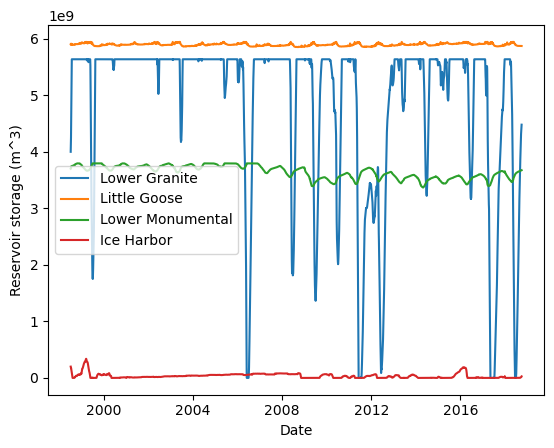

In [21]:
sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Monumental storage (m^3)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Ice Harbor storage (m^3)', data=input_data, label='Ice Harbor')

plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

## Simulate hydropower production

In [22]:
ice_harbor_head = ice_harbor.simulate_head(input_data['Ice Harbor storage (m^3)'].values)
input_data['Ice Harbor hydropower (kWh)'] = ice_harbor.simulate_hydropower(ice_harbor_head, input_data['Ice Harbor outflow (cfs)'].values, 1)

lower_mon_head = lower_monumental.simulate_head(input_data['Lower Monumental storage (m^3)'].values)
input_data['Lower Monumental hydropower (kWh)'] = ice_harbor.simulate_hydropower(lower_mon_head, input_data['Lower Monumental outflow (cfs)'].values, 1)

little_goose_head = little_goose.simulate_head(input_data['Little Goose storage (m^3)'].values)
input_data['Little Goose hydropower (kWh)'] = little_goose.simulate_hydropower(little_goose_head, input_data['Little Goose outflow (cfs)'].values, 1)

lower_granite_head = lower_granite.simulate_head(input_data['Lower granite storage (m^3)'].values)
input_data['Lower Granite hydropower (kWh)'] = lower_granite.simulate_hydropower(lower_granite_head, input_data['Lower Granite outflow (cfs)'].values, 1)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3),Lower Monumental inflow (m^3/d),Lower Monumental storage (m^3),Ice Harbor inflow (m^3/d),Ice Harbor storage (m^3),Ice Harbor hydropower (kWh),Lower Monumental hydropower (kWh),Little Goose hydropower (kWh),Lower Granite hydropower (kWh)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09,1.988958e+08,5.900000e+09,2.007032e+08,3.700000e+09,1.993017e+08,2.000000e+08,0.0,14472.0,21672.0,19440.0
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,4.039268e+09,1.915262e+08,5.898061e+09,1.958109e+08,3.701358e+09,1.944531e+08,1.963959e+08,0.0,14472.0,21672.0,19440.0
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,4.081182e+09,1.791393e+08,5.895931e+09,1.835147e+08,3.702606e+09,1.822666e+08,1.913003e+08,0.0,14472.0,21672.0,19440.0
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,4.126089e+09,1.666472e+08,5.893051e+09,1.716182e+08,3.703748e+09,1.704762e+08,1.849112e+08,0.0,14472.0,21672.0,19440.0
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,4.185436e+09,1.474847e+08,5.890486e+09,1.519528e+08,3.704712e+09,1.509886e+08,1.784096e+08,0.0,14472.0,21672.0,19440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,4.414207e+09,4.381166e+07,5.872012e+09,4.462513e+07,3.672411e+09,4.417843e+07,1.737258e+07,0.0,14472.0,21672.0,19440.0
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,4.430289e+09,4.528118e+07,5.872098e+09,4.595688e+07,3.672872e+09,4.549635e+07,2.001575e+07,0.0,14472.0,21672.0,19440.0
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,4.447093e+09,4.448162e+07,5.872152e+09,4.517875e+07,3.673327e+09,4.472369e+07,2.257335e+07,0.0,14472.0,21672.0,19440.0
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,4.463030e+09,4.521760e+07,5.872098e+09,4.603040e+07,3.673788e+09,4.556970e+07,2.446587e+07,0.0,14472.0,21672.0,19440.0


Text(0, 0.5, 'Hydropower Production (kWh)')

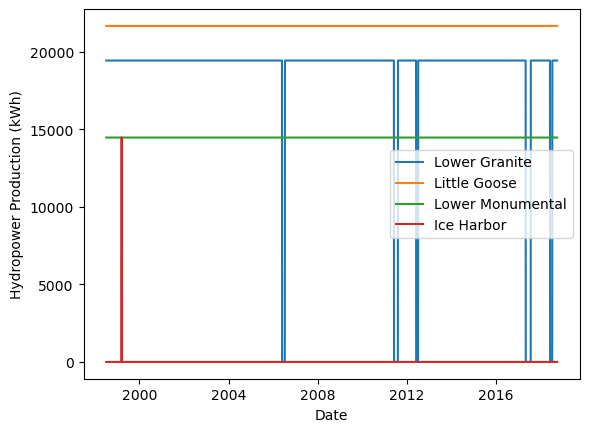

In [23]:
sns.lineplot(x='datetime', y='Lower Granite hydropower (kWh)', data=input_data, label='Lower Granite')
sns.lineplot(x='datetime', y='Little Goose hydropower (kWh)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Monumental hydropower (kWh)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Ice Harbor hydropower (kWh)', data=input_data, label='Ice Harbor')

plt.xlabel('Date')
plt.ylabel('Hydropower Production (kWh)')

## Calculate objective function